# RNN Time Series Forecasting

In [0]:
from google.colab import drive
drive.mount('/content/drive')
# check link: https://www.tensorflow.org/tutorials/structured_data/time_series#baseline

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# GPU memory utilization and package instalations
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
!pip install talos
import talos
import psutil
import humanize
import os
import GPUtil as GPU
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import SVG
import keras
from keras.utils.vis_utils import model_to_dot
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import pickle
import math
import pdb
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
  
random.seed(1234)
np.random.seed(1234)
%tensorflow_version 1.x
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=2175d777a77431502ee4bf7e9bca67ec285d6115c7d00bba5e1d0a9599a0b085
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
     |████████████████████████████████| 26.6MB 303kB/s 
     |████████████████████████████████| 839kB 45.6MB/s 
  Created wheel for talos: filename=talos-0.6.3-cp36-none-any.whl size=49626 sha256=80747686beb5f593b8e22ad7444e9cf0dd53038f6bb20dde3a3f875aa4628c3a
  Stored in directory: /root/.cache/pip/wheels/bb/d7/6b/86fd8b1fc7cfbd2c54796412f86efb5fb6a3a5c734014f6a66
  Created wheel for wrangle: filename=wrangle-0.6.7-cp36-none-any.whl size=49894 sha256=1284fdba863d5a546df38b91dba0af8fc3d264857d58842218946ceb13cfa391
  Stored in directory: /root/.cache/pip/wheels/bf/1b/50/d0403ce6ef269e364894da7b50db68db14c4ac62c577561e2d
  Created wheel for astetik: filename=astetik-1.9.9-cp36-none-any.whl size=56960 sha256=9

Using TensorFlow backend.


RAM Free: 12.6 GB  | Proc size: 371.8 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [0]:
%cd /content/drive/My\ Drive/DAUL
PATH = r"completeLoad.csv"
df = pd.read_csv(PATH)
df_h = df.set_index(['zone_id', 'year', 'month', 'day'])
unfolded_df = {}
for i, x in enumerate(tqdm(df_h.columns.tolist())):
    col_tuple = df_h[x].to_dict()
    for j, k in col_tuple.items():
        unfolded_df[tuple(list(j) + [i+1])] = k
n_df = pd.DataFrame.from_dict(unfolded_df, orient="index").sort_index()
m_index = pd.MultiIndex.from_tuples(unfolded_df.keys())
mi_df = pd.DataFrame(unfolded_df.values(), m_index).sort_index()
# convert pd.DateFrame to np.array of type float and group by zone
df_zone = np.array([mi_df.loc[(i+1)].values.astype("float32").reshape(
        len(mi_df.loc[(i+1)]),) for i in range(mi_df.index[-1][0])])

/content/drive/My Drive/DAUL


100%|██████████| 24/24 [00:00<00:00, 23.21it/s]


In [0]:
def plot_history(history, metric = None):
    if metric != None:
        fig, axes = plt.subplots(2,1)
        axes[0].plot(history.history[metric])
        try:
            axes[0].plot(history.history['val_'+metric])
            axes[0].legend(['Train', 'Val'], loc='best')
        except:
            pass
        axes[0].set_title('{:s}'.format(metric))
        axes[0].set_ylabel('{:s}'.format(metric))
        axes[0].set_xlabel('Epoch')
        fig.subplots_adjust(hspace=0.5)
        axes[1].plot(history.history['loss'])
        try:
            axes[1].plot(history.history['val_loss'])
            axes[1].legend(['Train', 'Val'], loc='best')
        except:
            pass
        axes[1].set_title('Model Loss')
        axes[1].set_ylabel('Loss')
        axes[1].set_xlabel('Epoch')
    else:
        plt.plot(history.history['loss'])
        try:
            plt.plot(history.history['val_loss'])
            plt.legend(['Train', 'Val'], loc='best')
        except:
            pass
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')

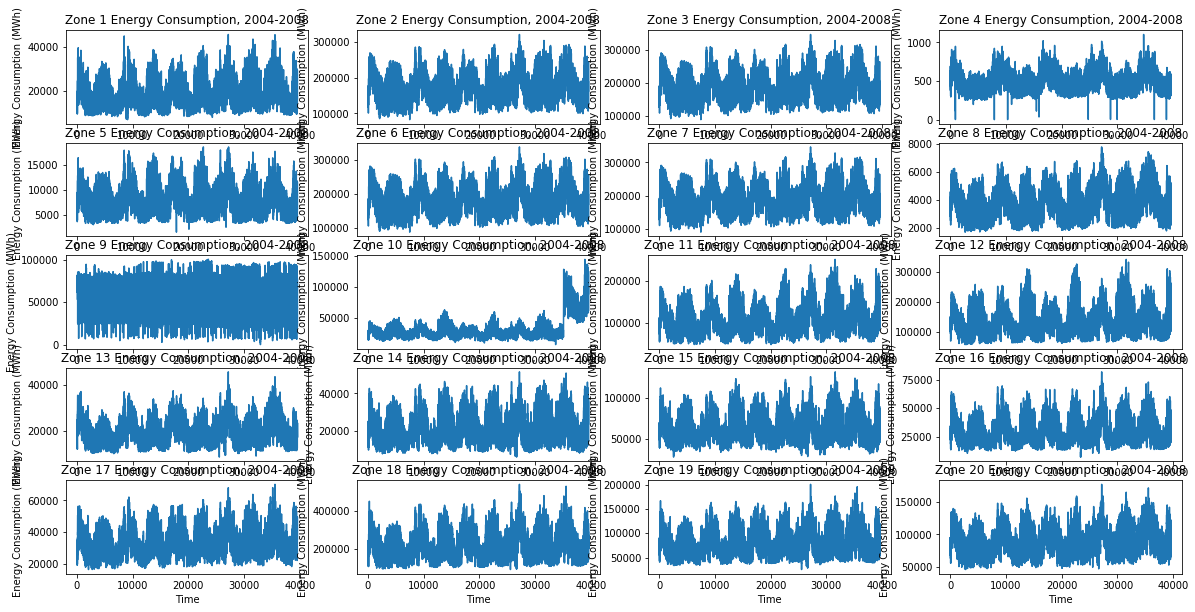

In [0]:
plt.figure(figsize = (20, 10))
for i, x in enumerate(df_zone):
    plt.subplot(5, 4, i+1)
    plt.plot(x)
    plt.xlabel("Time")
    plt.ylabel("Energy Consumption (MWh)")
    plt.title("Zone {} Energy Consumption, 2004-2008".format(i+1))
plt.show()

In [0]:
# use data for zone 2
data = df_zone[0].reshape(-1, 1)

# normalize data with min max normalization
normalizer = MinMaxScaler(feature_range = (0, 1))
dataset = normalizer.fit_transform(data)

# Using 80% of data for training, 20% for validation
TRAINING_PERC = 0.80

train_size = int(len(dataset) * TRAINING_PERC)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of samples training set: " + str((len(train))))
print("Number of samples test set: " + str((len(test))))

Number of samples training set: 31660
Number of samples test set: 7916


In [0]:
# helper function to read data
def create_dataset(dataset, window_size = 1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size - 1):
        sample = dataset[i:(i + window_size), 0]
        data_x.append(sample)
        data_y.append(dataset[i + window_size, 0])
    return(np.array(data_x), np.array(data_y))

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

def create_model(train_X, train_Y, window_size = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(LSTM(5, input_shape = (1, window_size), ))
    vanilla_rnn.add(Dense(1))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    return(vanilla_rnn)

In [0]:
window_size = 50
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model(train_X, train_Y, window_size)
# SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))

Train on 26825 samples, validate on 4734 samples
Epoch 1/100
26825/26825 [==============================] - 9s 323us/step - loss: 0.0096 - val_loss: 0.0027
Epoch 2/100
26825/26825 [==============================] - 6s 236us/step - loss: 0.0014 - val_loss: 0.0016
Epoch 3/100
26825/26825 [==============================] - 6s 239us/step - loss: 9.5140e-04 - val_loss: 9.5868e-04
Epoch 4/100
26825/26825 [==============================] - 6s 236us/step - loss: 7.1976e-04 - val_loss: 9.6638e-04
Epoch 5/100
26825/26825 [==============================] - 6s 238us/step - loss: 5.7811e-04 - val_loss: 5.8195e-04
Epoch 6/100
26825/26825 [==============================] - 6s 241us/step - loss: 4.8595e-04 - val_loss: 5.0411e-04
Epoch 7/100
26825/26825 [==============================] - 7s 250us/step - loss: 4.2335e-04 - val_loss: 5.6242e-04
Epoch 8/100
26825/26825 [==============================] - 6s 241us/step - loss: 3.9784e-04 - val_loss: 4.4096e-04
Epoch 9/100
26825/26825 [======================

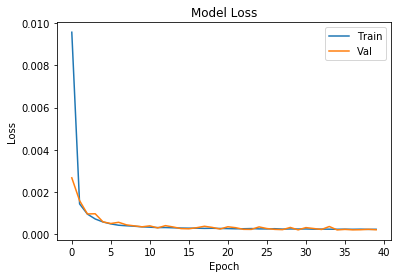

In [0]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 1, validation_split=0.15, callbacks=[es])
plot_history(history)

In [0]:
def get_predict_and_score(model, X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform([Y])
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

mse_train, train_predict = get_predict_and_score(vanilla_rnn, train_X, train_Y)
mse_test, test_predict = get_predict_and_score(vanilla_rnn, test_X, test_Y)

print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)


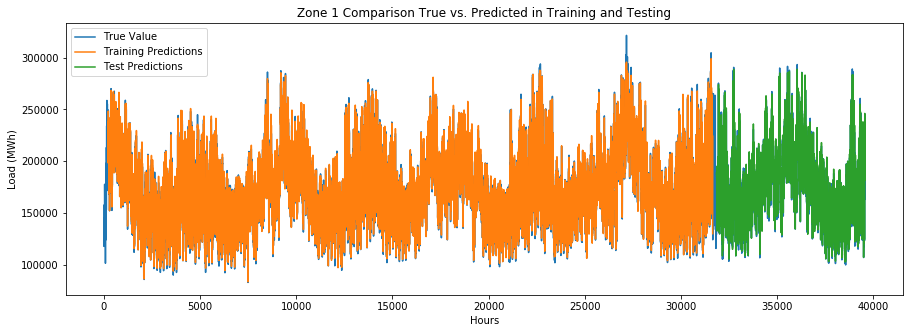

In [0]:
# Training predictions.
train_predictions = np.empty_like(dataset)
train_predictions[:, :] = np.nan
train_predictions[window_size:len(train_predict) + window_size, :] = train_predict

# Test predictions.
test_predictions = np.empty_like(dataset)
test_predictions[:, :] = np.nan
test_predictions[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(normalizer.inverse_transform(dataset), label = "True Value")
plt.plot(train_predictions, label = "Training Predictions")
plt.plot(test_predictions, label = "Test Predictions")
plt.xlabel("Hours")
plt.ylabel("Load (MWh)")
plt.title("Zone 1 Comparison True vs. Predicted in Training and Testing")
plt.legend()
plt.show()

In [0]:
from keras.layers.core import Dense, Activation, Dropout


## Hyperparameter tuning

In [0]:
def model_talos(train_X, train_Y, val_X, val_Y, params):
    vanilla_rnn = Sequential()

    for i in range(max(params['layers']-1, 0)):
      if params['dr_layers']:
        vanilla_rnn.add(Dropout(rate = params['rate']))
      vanilla_rnn.add(LSTM(params['first_lstm'], activation=params['activation'], return_sequences=True))

    vanilla_rnn.add(LSTM(params['first_lstm'], activation=params['activation'], 
                         recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform', 
                         recurrent_initializer='orthogonal', bias_initializer='zeros'))
    
    vanilla_rnn.add(Dense(1, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros'))
    
    vanilla_rnn.compile(params['optimizer'], loss='mse', metrcis=['mse', 'mae'])
    vanilla_rnn.optimizer.lr = params['lr']
    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0)
    history = vanilla_rnn.fit(train_X, train_Y, epochs = 20, batch_size = 32, 
                              verbose = 0,  validation_data=[val_X, val_Y], callbacks=[es])
    
    return history, vanilla_rnn

In [0]:
p = {'optimizer': ['adam', 'rmsprop', 'nadam', 'adamax'],
     'layers' : [1, 2, 3],
     'lr' : [0.02, 0.01, 0.005, 0.002, 0.001, 0.0005],
     'dr_layers' : [1, 0],
     'rate' : [0.2, 0.1, 0.5],
     'first_lstm' : [5, 20, 50, 100],
     'activation' : ['tanh', 'relu']}

scan_object = talos.Scan(train_X, train_Y, model=model_talos, params=p, fraction_limit=0.025, val_split=0.15, experiment_name='1')



  0%|          | 0/86 [00:00<?, ?it/s]


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.





  1%|          | 1/86 [02:10<3:04:13, 130.04s/it]

  2%|▏         | 2/86 [03:26<2:39:41, 114.06s/it]

  3%|▎         | 3/86 [04:40<2:21:10, 102.05s/it]

  5%|▍         | 4/86 [07:38<2:50:37, 124.85s/it]

  6%|▌         | 5/86 [09:50<2:51:22, 126.95s/it]

  7%|▋         | 6/86 [13:04<3:16:03, 147.04s/it]

  8%|▊         | 7/86 [14:22<2:46:09, 126.19s/it]

  9%|▉         | 8/86 [15:36<2:23:37, 110.48s/it]

 10%|█         | 9/86 [17:19<2:18:57, 108.28s/it]

 12%|█▏        | 10/86 [18:17<1:58:20, 93.42s/it]

 13%|█▎        | 11/86 [19:10<1:41:35, 81.27s/it]

 14%|█▍        | 12/86 [21:18<1:57:24, 95.19s/it]

 15%|█▌        | 13/86 [22:06<1:38:39, 81.09s/it]

 16%|█▋        | 14/86 [23:15<1:32:51, 77.39s/it]

 17%|█▋        | 15/86 [24:25<1:29:05, 75.29s/it]

 19%|█▊        | 16/86 [27:42<2:10:15, 111.66s/it]

 20%|█▉        | 17/86 [28:35<1:48:18, 94.18s/it] 

 21%|██        | 18/86 [29:20<1:29:56, 79.36s/it]

 22%|██▏       | 19/86 [30:05<1:16:57, 68.92s/it]

 23%|██▎       | 20/86 [31:

In [0]:
# accessing the results data frame
scan_object.data.head()

# accessing epoch entropy values for each round
scan_object.learning_entropy

# access the summary details
scan_object.details

experiment_name                       1
random_method          uniform_mersenne
reduction_method                   None
reduction_interval                   50
reduction_window                     20
reduction_threshold                 0.2
reduction_metric                val_acc
complete_time            12/01/19/13:28
x_shape                  (31609, 1, 50)
y_shape                        (31609,)
dtype: object

In [0]:
# use Scan object as input
analyze_object = talos.Analyze(scan_object)

# access the dataframe with the results
analyze_object.data

,round_epochs,val_loss,loss,activation,dr_layers,first_lstm,layers,lr,optimizer,rate
0,14,0.005280,0.005140,relu,1,20,3,0.0005,adamax,0.2
1,20,0.000328,0.000272,tanh,1,50,1,0.0005,adam,0.5
2,20,0.000219,0.000265,tanh,1,100,1,0.0100,adamax,0.2
3,20,0.000353,0.000532,relu,0,5,3,0.0020,rmsprop,0.1
4,20,0.000299,0.000275,relu,0,20,2,0.0020,adam,0.2
...,...,...,...,...,...,...,...,...,...,...
81,15,0.001134,0.000577,relu,1,100,2,0.0005,adam,0.1
82,20,0.000260,0.000303,relu,0,100,3,0.0050,adam,0.5
83,16,0.000390,0.000289,tanh,1,50,1,0.0200,adamax,0.5
84,16,0.005740,0.001990,relu,1,5,2,0.0050,adamax,0.2


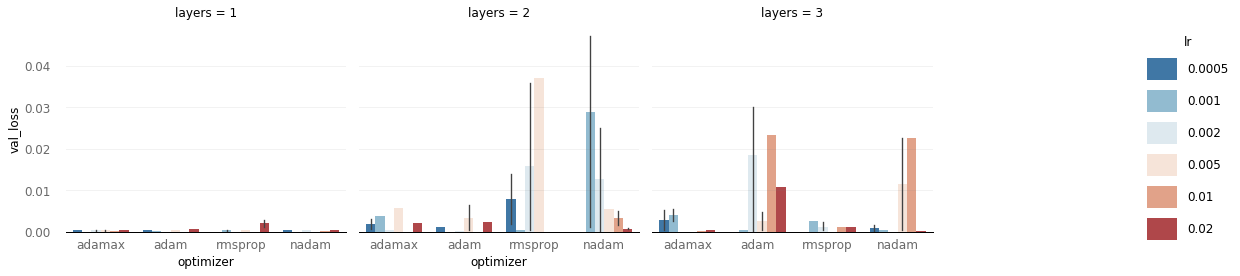

In [0]:
# four dimensional bar grid
analyze_object.plot_bars('optimizer', 'val_loss', 'lr', 'layers')

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


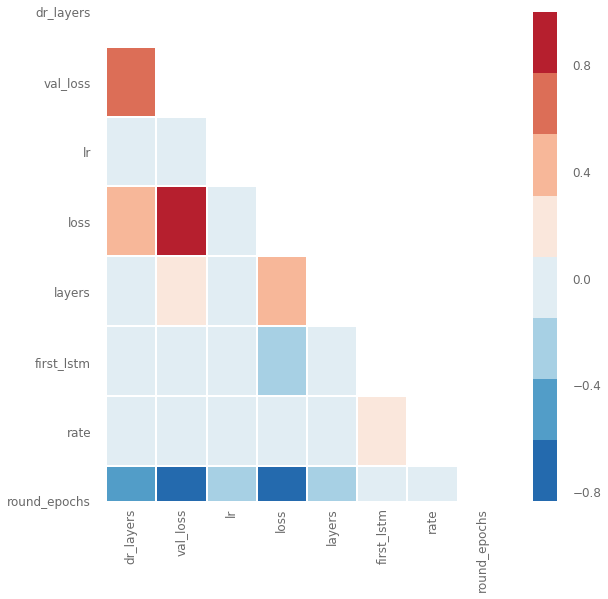

In [0]:
# heatmap correlation
analyze_object.plot_corr('val_loss', ['val_loss'])

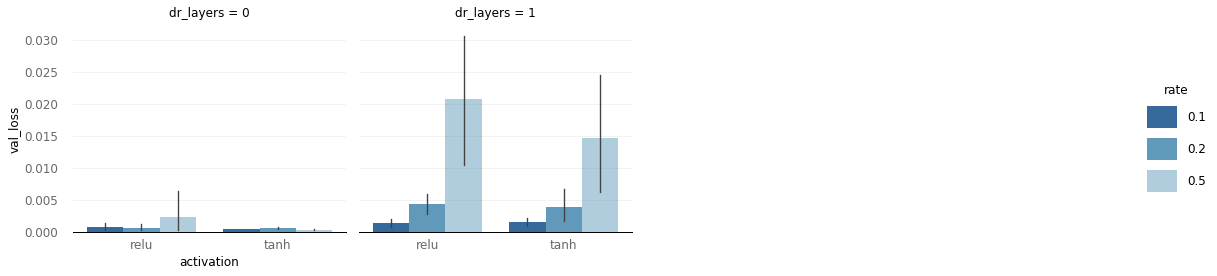

In [0]:

# four dimensional bar grid
analyze_object.plot_bars('activation', 'val_loss', 'rate', 'dr_layers')


Train on 26901 samples, validate on 4748 samples
Epoch 1/10
26901/26901 [==============================] - 7s 251us/step - loss: 0.0084 - val_loss: 0.0020
Epoch 2/10
26901/26901 [==============================] - 5s 189us/step - loss: 0.0014 - val_loss: 0.0011
Epoch 3/10
26901/26901 [==============================] - 5s 185us/step - loss: 0.0010 - val_loss: 8.7140e-04
Epoch 4/10
26901/26901 [==============================] - 5s 187us/step - loss: 8.2309e-04 - val_loss: 7.6472e-04
Epoch 5/10
26901/26901 [==============================] - 5s 181us/step - loss: 7.3436e-04 - val_loss: 6.6960e-04
Epoch 6/10
26901/26901 [==============================] - 5s 182us/step - loss: 6.8692e-04 - val_loss: 6.4193e-04
Epoch 7/10
26901/26901 [==============================] - 5s 182us/step - loss: 6.4892e-04 - val_loss: 6.1207e-04
Epoch 8/10
26901/26901 [==============================] - 5s 184us/step - loss: 6.2765e-04 - val_loss: 5.8037e-04
Epoch 9/10
26901/26901 [==============================] - 5

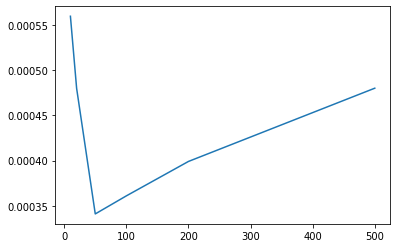

In [0]:
losses = []
iterator = [10, 20, 50, 100, 200, 500, 1000]
for i in iterator:
  window_size = i
  train_X, train_Y = create_dataset(train, window_size)
  test_X, test_Y = create_dataset(test, window_size)
  train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
  test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

  vanilla_rnn = create_model(train_X, train_Y, window_size)
  history = vanilla_rnn.fit(train_X, train_Y, epochs = 1000, batch_size = 32, verbose = 1, validation_split=0.15, callbacks=[es])
  losses.append(min(history.history['val_loss']))
plt.plot(iterator, losses)

Train on 26901 samples, validate on 4748 samples
Epoch 1/1000
26901/26901 [==============================] - 8s 309us/step - loss: 0.0090 - val_loss: 0.0028
Epoch 2/1000
26901/26901 [==============================] - 5s 183us/step - loss: 0.0019 - val_loss: 0.0016
Epoch 3/1000
26901/26901 [==============================] - 5s 180us/step - loss: 0.0013 - val_loss: 0.0010
Epoch 4/1000
26901/26901 [==============================] - 5s 180us/step - loss: 8.9305e-04 - val_loss: 7.6077e-04
Epoch 5/1000
26901/26901 [==============================] - 5s 179us/step - loss: 7.3885e-04 - val_loss: 6.4617e-04
Epoch 6/1000
26901/26901 [==============================] - 5s 181us/step - loss: 6.7919e-04 - val_loss: 6.8039e-04
Epoch 7/1000
26901/26901 [==============================] - 5s 182us/step - loss: 6.4617e-04 - val_loss: 6.0964e-04
Epoch 8/1000
26901/26901 [==============================] - 5s 179us/step - loss: 6.1401e-04 - val_loss: 5.4407e-04
Epoch 9/1000
26901/26901 [=====================

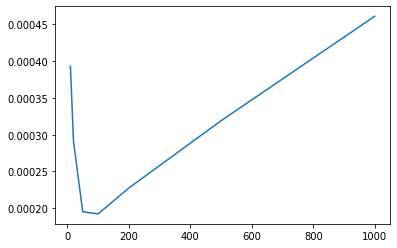

In [0]:
losses = []
iterator = [10, 20, 50, 100, 200, 500, 1000]
for i in iterator:
  window_size = i
  train_X, train_Y = create_dataset(train, window_size)
  test_X, test_Y = create_dataset(test, window_size)
  train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
  test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
  es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
  vanilla_rnn = create_model(train_X, train_Y, window_size)
  history = vanilla_rnn.fit(train_X, train_Y, epochs = 1000, batch_size = 32, verbose = 1, validation_split=0.15, callbacks=[es])
  losses.append(min(history.history['val_loss']))
plt.plot(iterator, losses)

In [0]:
plt.savefig("window_size", dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

<Figure size 432x288 with 0 Axes>